### Imports and settings for this notebool

In [1]:
# general notebook formatting for markdown and plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings = lambda *a, **kw: None
from IPython.core.display import HTML

In [2]:
# imports for code examples
import os

from pygromos.files.gromos_system.gromos_system import Gromos_System
from pygromos.files.gromos_system.ff.forcefield_system import forcefield_system
from pygromos.files.simulation_parameters.imd import Imd

from pygromos.simulations.modules.preset_simulation_modules import sd
from pygromos.simulations.modules.preset_simulation_modules import emin
from pygromos.data.simulation_parameters_templates import template_sd, template_emin_vac

# PyGromosToolsDay

## Introduction

This notebook is created for the PyGromosToolsDay 17.02.2022    
Author: Marc Thierry Lehner  

This notbook is part of the PyGromosTools and can be found under:
https://github.com/rinikerlab/PyGromosTools/blob/pygromosDay/examples/PyGromosToolsDay/pyGromosToolsDay.ipynb

### Schedul for the day

1. [Introduction](#Introduction)
    1. [Schedule](#Schedule)
    2. [Tutorial](#Tutorial)
2. [PyGromosTools](#PyGromosTools)
    1. [PyGromosTools](#PyGromosTools)
    2. [PyGromosTools](#PyGromosTools)

## PyGromosTools - a Python package for GROMOS users

PyGromosTools is a Python package for GROMOS users. It tries to provide a easy to use unified interface to the GROMOS users in python. Leading to a better readability and reproducability of code, as well as easier pipelining of GROMOS simulations.

PyGromosTools is a natural grown package which tries to adhere to all GROMOS user's needs.

At the current state PyGromosTools provides:
1. GROMOSxx wrappers
2. GROMOS++ wrappers
3. File handling of all GROMOS file types for automated creation/modification/analysis
4. Automation and file management system gromos_system
5. Simulation Submission and Execution
6. etc.

In the following sections we will see how to use PyGromosTools to automate the creation of GROMOS simulations and how these tools are intended to be used. We will show simple uscase and how to adjust existing classes to fit more complex simulations or new blocks and finally show how you can contribute to PyGromosTools.

### General File Structure

Since the second major relase (TODO: date???) PyGromosTools is focused around a class called `gromos_system`. This class is the main class of PyGromosTools and is used to create, manage and analyse GROMOS simulations.  

`gromos_system` stores information of all files of a simulation and provides methods to create, modify and analyse these files.


<p style="text-align:center;">
    <img src="./figures/gromos_system_overview.png" width=900 alt="gromos_system_overview"/>
    <div style="text-align:center;">Based on B. Ries Thesis</div>
</p> 

`gromos_system` can be create in many different ways. The simplest way is from existing files. However, it also provides the option to be created from only a smiles and a forcfield.  

Although it has to be mentioned, that for all GROMOS types forcefields the correct MTB name is required.  

In the following example we create first a `forcefield_system` that holds all informations about the forcfield we want to use, and then use this `forcefield_system` to create a `gromos_system` from a smiles.   

If we tick the option `adapt_imd_automatically` and `auto_convert` in `gromos_system` we will automatically create not only the topology, but also the coordinate file and a adjusted INPUT file.

In [3]:
work_dir = os.path.abspath("./example_sys/")

In [4]:
ff = forcefield_system(name="2016H66")
ff.mol_name = "BZN"

In [5]:
groSys = Gromos_System(work_folder=work_dir,
                system_name="test_system",
                in_smiles="c1ccccc1", 
                Forcefield=ff, 
                adapt_imd_automatically=True,
                in_imd_path=template_emin_vac, 
                auto_convert=True)

This `gromos_system` called `groSys` now contains a topology, coordinate and a input file for Cyclohexane. All automatically generated.  

We can access all these files as python classes by accessing the `groSys.top`, `groSys.cnf` and `groSys.imd` attributes.  
All these classe are instances of the `gromos_file` class and have attributes on their own which are the gromos blocks (and of course somties additional content).  

For example we can check if the new topology has a proper TITLE block by accessing the attribute `groSys.top.TITLE`. And we can see, that as expected the title block was automatically generated.

In [6]:
#help(groSys.top.TITLE)

In [7]:
groSys.top.TITLE

TITLE
MAKE_TOP topology, using:
/home/mlehner/PyGromosTools/pygromos/data/ff/Gromos2016H66/2016H66.mtb
/home/mlehner/PyGromosTools/pygromos/data/ff/Gromos2016H66/2016H66_orga.mtb
/home/mlehner/PyGromosTools/pygromos/data/ff/Gromos2016H66/2016H66.ifp

Force-field code: 2016H66

	 >>> Generated with PyGromosTools (riniker group) <<< 
END

The same is also true for the other files. It's espicially worth to mention that coordinate file is automatically generated, using the RDKit conformer generator.

In [8]:
groSys.cnf.POSITION

POSITION
# 	 
    1 BZN   C1         1    0.080600000   -0.114300000    0.001500000
    1 BZN   H1         2    0.143435194   -0.203358253    0.002668736
    1 BZN   C2         3    0.139300000    0.012700000   -0.000200000
    1 BZN   H2         4    0.247852856    0.022561710   -0.000355389
    1 BZN   C3         5    0.058700000    0.127000000   -0.001700000
    1 BZN   H3         6    0.104422350    0.225937924   -0.003024364
    1 BZN   C4         7   -0.080600000    0.114300000   -0.001500000
    1 BZN   H4         8   -0.143435194    0.203358253   -0.002668736
    1 BZN   C5         9   -0.139300000   -0.012700000    0.000200000
    1 BZN   H5        10   -0.247852856   -0.022561710    0.000355389
    1 BZN   C6        11   -0.058700000   -0.127000000    0.001700000
    1 BZN   H6        12   -0.104422350   -0.225937924    0.003024364
END

All these blocks the contain classes for the specific fields. In the case of the POSITION block we have a list of atoms. And each atom stores the name, the type and the position. This makes it easy to make adjustments, search for specific atoms or do some general scripted modifiactions to the positions.

<p style="text-align:center;">
    <img src="./figures/gromos_file.png" height=300 alt="gromos file structure"/>
    <div style="text-align:center;">Based on B. Ries Thesis</div>
</p> 

All the fields have theire own attributs and sometimes functions to modify them. For example the `POSITION` block has a `atomP` that store all the information.

In [9]:
atomP = groSys.cnf.POSITION[1]
print(atomP.atomID, atomP.atomType, atomP.resName, atomP.xp)

2 H1 BZN 0.143435194


All cnf files can be easily converted to differet file types (eg. pdb) and checked via the handy `visualize` function. The `visualize` function is intended for notebooks and prototyping, but can be used for any other purpose. It's a fully interactive 3D view.

In [10]:
groSys.cnf.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

### Simple Simulation

PyGromosTools provides a simple way to create a GROMOS simulation. This is done by creating a `gromos_system` and then adding the necessary files to it and then simply selecting one of the preset modules.  

PyGromosTools offers a wide range of preset simulations, but also general simulation templates, which can be easily modified.  

These simulation modules take care of the creation of the necessary files, the execution/scheduling of the simulation, cleaning up the files and the analysis of the results.

<p style="text-align:center;">
    <img src="./figures/simulation_structure.png" width=600 alt="gromos simulation structure"/>
    <div style="text-align:center;">Based on B. Ries Thesis</div>
</p> 

The core of of all simulations is a `general_simulation` class. This class is the base class for all simulations. It provides the basic functionality to create the necessary files, the execution/scheduling of the simulation, cleaning up the files and the analysis of the results. Simple extensions to this class are classes like `MD`, `SD` and `EMIN` which manly provide preset changes in the IMD file. However PyGrromosTools also provides a wide range of more complex simulation approaches like `Hvap`, `TI`, etc. wich often require multiple lower level simulations to be run.

But in all simulation modules the date is always stored and returned in a `gromos_system` object. This is done to make it easy for users to keeep files clean and analyse the results. And all simulation modules use a so called `submission_system`. These classes store the information about the submission of the simulation on a specific platform.


In [11]:
eminGroSys = emin(groSys, in_imd_path=template_emin_vac)

################################################################################

emin
################################################################################

FOUND RESULT: /home/mlehner/PyGromosTools/examples/PyGromosToolsDay/example_sys/emin/analysis/data/emin.cnf
 GOING TO SKIPT THIS SUBMISSION!


In [12]:
sdGroSys = sd(eminGroSys, in_imd_path=template_sd)

################################################################################

sd
################################################################################

FOUND RESULT: /home/mlehner/PyGromosTools/examples/PyGromosToolsDay/example_sys/sd/analysis/data/sd.cnf
 GOING TO SKIPT THIS SUBMISSION!


After some simulations we still have a `gromos_system` object. This object contains all the files of the simulation. Even trajectories are added to the `gromos_system` object automatically.  
In case files are not automatically attached (for example due to scheduling on a cluster) they can be added automatically via the function `_check_promises()`. This function will go through all files and update them. Some files might only be attached as `future_files` and read in after this function call. `future_files` are files that are not yet available and allow for more flexibility on clusters where jobs might be submitted before the files are available.

In [13]:
sdGroSys._check_promises()

### Simple analysis

At this stage we successfully ran a GROMOS simulation with PyGromosTools. But we still have to analyse the results. Most analysis is done using the trajectories and these classes offer a lot of helping functions.  
Trajectories are in PyGromosTools stored as Pandas DataFrames. This makes it easy and fast to analyse the results. Every type of trajectoriy contains a attribute called `database` which is a Pandas DataFrame. This DataFrame contains all the information of the trajectory. And a user could access it in any way he likes, like a normal DataFrame. However, for most common analysis tasks functions are already provided by the respective trajectory class.  
For example, if we want to compare the distance of a atom to another atom during the simulation we could use the following lines of code:

In [14]:
sdGroSys.cnf.visualize()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [15]:
sdGroSys.trc.database

,TIMESTEP_step,TIMESTEP_time,POS_1,POS_2,POS_3,POS_4,POS_5,POS_6,POS_7,POS_8,POS_9,POS_10,POS_11,POS_12
0,0,0.000,"[0.079293949, -0.115350911, 0.001069465]","[0.142141436, -0.204390119, 0.002038194]","[0.137561643, 0.010824028, -0.000732479]","[0.246110591, 0.020729732, -0.000677102]","[0.057415117, 0.124380084, -0.00180149]","[0.103104793, 0.223323376, -0.00308404]","[-0.081009078, 0.111743506, -0.00204579]","[-0.143854971, 0.200790872, -0.003018626]","[-0.139274691, -0.014427247, -0.000244167]","[-0.247823617, -0.024333163, -0.000306279]","[-0.059130551, -0.127984375, 0.000838247]","[-0.104827497, -0.226930389, 0.002110119]"
1,1,0.001,"[0.079278068, -0.113983263, 0.00116419]","[0.142830725, -0.202507232, 0.003633213]","[0.137727436, 0.010563691, -0.000813528]","[0.246211768, 0.021076942, 0.000537359]","[0.059184559, 0.124660831, -0.002701836]","[0.106007722, 0.223090246, -0.003366005]","[-0.081463221, 0.111815707, -0.000746384]","[-0.145161109, 0.200237398, -0.003023504]","[-0.138389573, -0.013518925, -2.6415e-05]","[-0.246803034, -0.023766872, -0.004806668]","[-0.058694813, -0.128575615, 0.000789086]","[-0.103891493, -0.227748292, -0.000990459]"
2,2,0.002,"[0.079359804, -0.112867892, 0.001443057]","[0.144477771, -0.200198761, 0.005181344]","[0.1378592, 0.010313039, -0.000842636]","[0.24635752, 0.020492367, 0.001531612]","[0.060629828, 0.125039045, -0.003803059]","[0.108495517, 0.222966905, -0.0039326]","[-0.081796806, 0.112124923, 0.000425624]","[-0.146275922, 0.199956587, -0.00258521]","[-0.137390219, -0.012756159, 1.2355e-05]","[-0.245443327, -0.023926582, -0.008977645]","[-0.058472575, -0.129223395, 0.000591432]","[-0.102946977, -0.228646736, -0.003654699]"
3,3,0.003,"[0.079407188, -0.111995171, 0.001806067]","[0.14634435, -0.197935175, 0.005655246]","[0.137893657, 0.010429766, -0.000963031]","[0.246446107, 0.019455242, 0.003031625]","[0.061742068, 0.125519076, -0.004800577]","[0.110906, 0.222800511, -0.0052925]","[-0.082100551, 0.112522133, 0.001542179]","[-0.147522593, 0.199665228, -0.001111745]","[-0.136483329, -0.01225655, -6.4365e-05]","[-0.244160349, -0.022867689, -0.013257693]","[-0.058520322, -0.129891214, 0.000288167]","[-0.101662216, -0.229834963, -0.005284002]"
4,4,0.004,"[0.079574905, -0.111417416, 0.002188221]","[0.148073312, -0.196103779, 0.006339564]","[0.137752347, 0.010560604, -0.000982489]","[0.246333301, 0.017983854, 0.005023715]","[0.06288677, 0.126100645, -0.005777064]","[0.113583072, 0.222581095, -0.007340681]","[-0.082306297, 0.113037783, 0.002485077]","[-0.149784924, 0.198615097, 0.000444639]","[-0.135741189, -0.012133984, -0.000400216]","[-0.242997066, -0.021091254, -0.017632336]","[-0.058498638, -0.130520462, -9.7311e-05]","[-0.100129976, -0.231045093, -0.006628481]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.095,"[0.108138026, -0.100965956, -0.00133106]","[0.179346537, -0.183038819, 0.007294287]","[0.143419603, 0.034476719, 0.001848471]","[0.247560214, 0.057113405, 0.024732052]","[0.054009963, 0.137804425, 0.000144716]","[0.080511293, 0.241610219, 0.020222434]","[-0.080101149, 0.109911479, -0.011804003]","[-0.159650467, 0.184222222, -0.017370888]","[-0.115424239, -0.027545732, -0.006780056]","[-0.221788469, -0.049893521, -0.015042862]","[-0.028572892, -0.131726507, 0.00350057]","[-0.058937798, -0.235401983, 0.01800557]"
96,96,0.096,"[0.108356696, -0.100037307, -0.001458296]","[0.178572992, -0.18322993, 0.003851748]","[0.14377582, 0.034292503, 0.00157822]","[0.247120266, 0.059032214, 0.025845005]","[0.054528814, 0.13906628, -0.000151529]","[0.080244204, 0.242764395, 0.021445228]","[-0.079447229, 0.110224112, -0.01148075]","[-0.158551942, 0.184978013, -0.017423108]","[-0.115898214, -0.026980966, -0.006055717]","[-0.22136199, -0.052377104, -0.016789022]","[-0.028264015, -0.132167939, 0.00355255]","[-0.059183235, -0.235733205, 0.017668843]"
97,97,0.097,"[0.108309809, -0.099316216, -0.001454185]","[0.177988139, -0.183103572, 0.000928125]","[0.144509747, 0.034066205, 0.001264

<AxesSubplot:>

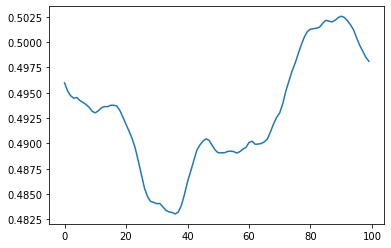

In [16]:
sdGroSys.trc.get_atom_pair_distance_series(2, 8).plot()

Similar to cnf files trc files also provide a `visualize` function. The function will show a 3D video of the trajectory.

In [18]:
sdGroSys.trc.visualize(sdGroSys.cnf)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

And similar to the trc files tre files also provide a wide selection of analysis tools out of the box.

<AxesSubplot:>

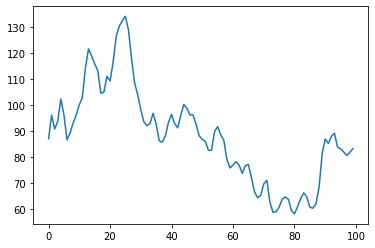

In [22]:
sdGroSys.tre.get_totals_total().plot()

### Non standart blocks and modifications

When devloping with Gromos or experimenting with new features it can happen that we need to use blocks which are not default blocks in Gromos, and therefore not out of the box supported by PyGromosTools. However, PyGromosTools is build up highly modular and flexible and many exstenions are easy to implement.  
This can normally be done at very different levels. All files classes in PyGromosTools follow a specific structure and offer different implementations to read/write/modifie the files.  

In the following section we will have a look at a possible modification to a IMD file and the structure of IMD files.

In [ ]:
test_imd = Imd(template_sd)

`Imd`is a `_general_gromos_file` class. While the `_general_gromos_file` class already has default implementations for reading and writing (`read_file`and `to_string`) these are mostly overwritten by the `Imd` class to suit the special needs of IMD files.  

The `Imd` class then contains all the IMD-blocks as attributes. These attributes are instances of the `pygromos.files.blocks.imd_blocks` classes. These blocks the again contain theire own read/write functions which are called from the `Imd` class top down. And every block again may have smaller classes for individual fields with theire own read/write functions.  

If we look at a simple example of a block like the SYSTEM block we can achive a deeper understanding of the underlying structure.

In [ ]:
from pygromos.files.blocks.imd_blocks import _generic_imd_block
class testSYSTEM(_generic_imd_block):
    #removed documentation for this example. Original code can be found in pygromos.files.blocks.imd_blocks:145
    name: str = "testSYSTEM"
    # fields
    NPM: int  # number of Solute Molecules
    NSM: int  # number of Solvent Molecules

    _order = [[["NPM", "NSM"]]]

    def __init__(self, NPM:int=0, NSM:int=0, content=None):
        super().__init__(used=True, content=content)
        if content is None:
            self.NPM = int(NPM)
            self.NSM = int(NSM)

The `SYSTEM` block is a `_generic_imd_block` class. And in this simple case we can use the default implemnation of all block specific functions like `read_content_from_str`and `block_to_string` provided by `_generic_imd_block`. These functions are set by the `super` call in the `__init__` function.  
All we are doing is telling the super class the keys to expect via the `_order` list and the conversion of the attributes to the right types. The `_order` attribute allways is a 3D list. Where th inner 2D are corresponding to lines and fields in the block. For example we could add another field called "test" which we expect to be in the next line by writting:

In [ ]:
_order = [[["NPM", "NSM"]["test"]]]

As long as the block does not contain matrices (like PRESSURESCALE) the default implementation of read/write functions should be sufficient. However, with more complex blocks there might be a need to overload these functions.

Since `_order`is a attribute of the block class we can easily modify it on the fly. Or if we are always using a specific order we can simply overwrite the `_order` attribute in the file. This is also a easy way to update PyGromosTools to new versions of Gromos blocks.

### New files for new gromos functionality

## Release 3

## Hackathlon

## Final Disscussion